In [ ]:
# installs

!pip install joblib

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# imports

import pandas as pd
import os
import json
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/cardekho_dataset"

In [ ]:
def get_details(new_car_detail):
        # replace new_car_detail for tidyups
        new_car_detail = new_car_detail.replace("'", '"')
        new_car_detail = new_car_detail.replace("None", 'null')

        new_car_detail_json = json.loads(new_car_detail)
        row = {}
        row["it"] = new_car_detail_json["it"]
        row["ft"] = new_car_detail_json["ft"]
        row["bt"] = new_car_detail_json["bt"]

        row["km"] = new_car_detail_json["km"].replace(",", '')
        row["transmission"] = new_car_detail_json["transmission"]

        row["ownerNo"] = new_car_detail_json["ownerNo"]
        row["owner"] = new_car_detail_json["owner"]
        row["oem"] = new_car_detail_json["oem"]
        row["model"] = new_car_detail_json["model"]
        row["modelYear"] = new_car_detail_json["modelYear"]
        row["centralVariantId"] = new_car_detail_json["centralVariantId"]

        row["variantName"] = new_car_detail_json["variantName"]
        row["price"] = new_car_detail_json["price"]
        row["priceActual"] = new_car_detail_json["priceActual"]
        row["priceSaving"] = new_car_detail_json["priceSaving"]
        row["priceFixedText"] = new_car_detail_json["priceFixedText"]
        return row

In [ ]:
def get_overview_features(new_car_overview):
    row = {}
    new_car_overview = new_car_overview.replace("'", '"')
    new_car_overview = new_car_overview.replace("None", 'null')

    new_car_overview_json = json.loads(new_car_overview)

    top_features = new_car_overview_json["top"]
    for feature in top_features:
        row[feature["key"]] = feature["value"]
    return row


In [ ]:
def get_features(new_car_features):
    row = []
    new_car_features = new_car_features.replace("'", '"')
    new_car_features = new_car_features.replace("None", 'null')

    new_car_features_json = json.loads(new_car_features)

    top_features = new_car_features_json["top"]

    for feature in top_features:
        row.append(feature["value"])
    return row


In [ ]:
def get_top_specs(car_specs_data):
    row = {}
    new_car_specs = car_specs_data.replace("'", '"')
    new_car_specs = new_car_specs.replace("None", 'null')

    new_car_specs_json = json.loads(new_car_specs)

    top_specs = new_car_specs_json["top"]

    for spec in top_specs:
        row[spec["key"]] = spec["value"]
    return row

In [ ]:
# main cell

# Reads all city data(xls used cars dataset) from given path
# uses respective functions to get relevant part of data
# finally loads the raw data into df

dataset_files = [f for f in os.listdir(DATASET_PATH) if f.endswith('.xlsx')]
len(dataset_files)

json_data_list = []

concatenated_df = pd.DataFrame()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# get all city dataset files and appemd to json_data_list
for file in dataset_files:
    df = pd.read_excel(io=DATASET_PATH+"/"+file, header=0)
    json_data = df.to_json(orient='records')
    json_data_list.append(json_data)


# loop through all the json_data_list and append to concatenated_df
for json_str in json_data_list:
    json_data = json.loads(json_str)

    for index in range(len(json_data)):
        # EACH ROW in EXCEL
        ROW = {}
        new_car_detail = json_data[index]["new_car_detail"]
        features_row = get_details(new_car_detail)
        ROW.update(features_row)

        new_car_overview = json_data[index]["new_car_overview"]
        overview_row = get_overview_features(new_car_overview)
        ROW.update(overview_row)

        # new_car_features = json_data[index]["new_car_feature"]
        # features_list = get_features(new_car_features)
        # ROW["top_features"] = features_list

        car_specs = json_data[index]["new_car_specs"]
        specs = get_top_specs(car_specs)
        ROW.update(specs)

        dfx = pd.DataFrame([ROW])
        concatenated_df = pd.concat([concatenated_df, dfx], ignore_index=True)

concatenated_df.head()

,it,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,centralVariantId,variantName,price,priceActual,priceSaving,priceFixedText,Registration Year,Insurance Validity,Fuel Type,Seats,Kms Driven,RTO,Ownership,Engine Displacement,Transmission,Year of Manufacture,Mileage,Engine,Max Power,Torque,Wheel Size
0,0,Petrol,Hatchback,120000,Manual,3,3rd Owner,Maruti,Maruti Celerio,2015,3979,VXI,₹ 4 Lakh,,,None,2015,Third Party insurance,Petrol,5,"1,20,000 Kms",KA51,Third Owner,998 cc,Manual,2015.00,23.1 kmpl,998 CC,67.04bhp,90Nm,NaN
1,0,Petrol,SUV,32706,Manual,2,2nd Owner,Ford,Ford Ecosport,2018,6087,1.5 Petrol Titanium BSIV,₹ 8.11 Lakh,,,None,Feb 2018,Comprehensive,Petrol,5,"32,706 Kms",KA05,Second Owner,1497 cc,Manual,2018.00,17 kmpl,1497 CC,121.31bhp,150Nm,16
2,0,Petrol,Hatchback,11949,Manual,1,1st Owner,Tata,Tata Tiago,2018,2983,1.2 Revotron XZ,₹ 5.85 Lakh,,,None,Sept 2018,Comprehensive,Petrol,5,"11,949 Kms",KA03,First Owner,1199 cc,Manual,2018.00,23.84 kmpl,1199 CC,84bhp,114Nm,14
3,0,Petrol,Sedan,17794,Manual,1,1st Owner,Hyundai,Hyundai Xcent,2014,1867,1.2 Kappa S Option,₹ 4.62 Lakh,,,None,Dec 2014,Comprehensive,Petrol,5,"17,794 Kms",KA53,First Owner,1197 cc,Manual,2014.00,19.1 kmpl,1197 CC,81.86bhp,113.75Nm,14
4,0,Diesel,SUV,60000,Manual,1,1st Owner,Maruti,Maruti SX4 S Cross,2015,4277,DDiS 200 Zeta,₹ 7.90 Lakh,,,None,2015,Third Party insurance,Diesel,5,"60,000 Kms",KA04,First Owner,1248 cc,Manual,2015.00,23.65 kmpl,1248 CC,88.5bhp,200Nm,16


In [ ]:
# cleaning
    # remove unnecessary columns

# reason
# it: only unique values
# oem: centralVariantId captures this detail with other
# owner & Ownership: anotehr column with ownerNo has the data numerically
# Kms Driven anotehr column km has the same data
# Registration Year, Model year - anotehr column Year of Manufacture has the same data
# model, variantName - anotehr columns centralVariantId has the same data
# price only one actual price columns retained and rest dropped
# Engine Displacement has same value as Engine

df2 = concatenated_df.drop(["it","oem", "RTO", "owner", "Ownership", "Kms Driven", "Registration Year", "modelYear", "model", "variantName", \
                            "priceFixedText", "priceSaving", "priceActual", "Engine", "Transmission", "centralVariantId", \
                            "Wheel Size", 'Insurance Validity', 'Fuel Type'], axis=1)


df2.head()

,ft,bt,km,transmission,ownerNo,price,Seats,Engine Displacement,Year of Manufacture,Mileage,Max Power,Torque
0,Petrol,Hatchback,120000,Manual,3,₹ 4 Lakh,5,998 cc,2015.00,23.1 kmpl,67.04bhp,90Nm
1,Petrol,SUV,32706,Manual,2,₹ 8.11 Lakh,5,1497 cc,2018.00,17 kmpl,121.31bhp,150Nm
2,Petrol,Hatchback,11949,Manual,1,₹ 5.85 Lakh,5,1199 cc,2018.00,23.84 kmpl,84bhp,114Nm
3,Petrol,Sedan,17794,Manual,1,₹ 4.62 Lakh,5,1197 cc,2014.00,19.1 kmpl,81.86bhp,113.75Nm
4,Diesel,SUV,60000,Manual,1,₹ 7.90 Lakh,5,1248 cc,2015.00,23.65 kmpl,88.5bhp,200Nm


In [ ]:
# # convert Wheel Size with Radial info to just diameter, for example R16 will be converted to numeric 16

# df3 = df2.copy()

# def extract_numeric(s):
#     if pd.isna(s):
#        return pd.NA  # Return NaN if the value is NaN
#     match = re.search(r'\d+', s)
#     val = int(int(match.group()))
#     return val if match else pd.nan


# df3['Wheel Size'] = df3['Wheel Size'].apply(extract_numeric)


In [ ]:
# df4 = df3.copy()

# wheel_size_mean = int(df4["Wheel Size"].mean())
# wheel_size_mean
# df4['Wheel Size'] = df4['Wheel Size'].fillna(wheel_size_mean)


In [ ]:
# cleaning bt column remove empty, nan values

df2.replace("", np.nan, inplace=True)
df2.dropna(subset=['bt'], inplace=True)


In [ ]:
# one hot enconding of catergorical data

df3 = df2.copy()

df3 = pd.get_dummies(df3, columns=['ft', 'bt', 'transmission'], dtype=int)

df3.head()

,km,ownerNo,price,Seats,Engine Displacement,Year of Manufacture,Mileage,Max Power,Torque,ft_Cng,ft_Diesel,ft_Electric,ft_Lpg,ft_Petrol,bt_Convertibles,bt_Coupe,bt_Hatchback,bt_Hybrids,bt_MUV,bt_Minivans,bt_Pickup Trucks,bt_SUV,bt_Sedan,bt_Wagon,transmission_Automatic,transmission_Manual
0,120000,3,₹ 4 Lakh,5,998 cc,2015.00,23.1 kmpl,67.04bhp,90Nm,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,32706,2,₹ 8.11 Lakh,5,1497 cc,2018.00,17 kmpl,121.31bhp,150Nm,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,11949,1,₹ 5.85 Lakh,5,1199 cc,2018.00,23.84 kmpl,84bhp,114Nm,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,17794,1,₹ 4.62 Lakh,5,1197 cc,2014.00,19.1 kmpl,81.86bhp,113.75Nm,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
4,60000,1,₹ 7.90 Lakh,5,1248 cc,2015.00,23.65 kmpl,88.5bhp,200Nm,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
# convert string price (lakhs, Crore)value to numerical format


df4 = df3.copy()

LAKH = 100000
CRORE = 10000000

def get_numerical_price(price):
    if price.find("Lakh") != -1:
        parts = price.split()
        if len(parts) == 3:
            return float(parts[1]) * LAKH
        else:
            return pd.NA
    elif price.find("Crore") != -1:
        parts = price.split()
        if len(parts) == 3:
            return float(parts[1]) * CRORE
        else:
            return pd.NA

    else:
        parts = price.split()
        # remove comma from price and convert to float
        pricef = parts[1].replace(",", "")
        return float(pricef)

df4["price"] = df4["price"].apply(get_numerical_price)



In [ ]:
# convert different forms(kmpl, km/kg) of mileage to numeric format

df5 = df4.copy()

def mileage_convert(x):
    if type(x) == str:
        if x.split()[-1] == 'km/kg':
            return float(x.split()[0])*1.40 #formula
        elif x.split()[-1] == 'kmpl':
            return float(x.split()[0])
    else:
        return x

df5['Mileage'] = df5['Mileage'].apply(mileage_convert)

df5 = df5.dropna(subset=['Mileage'])
# dropping na as only 287 rows are na

In [ ]:
df6 = df5.copy()

df6.head()

,km,ownerNo,price,Seats,Engine Displacement,Year of Manufacture,Mileage,Max Power,Torque,ft_Cng,ft_Diesel,ft_Electric,ft_Lpg,ft_Petrol,bt_Convertibles,bt_Coupe,bt_Hatchback,bt_Hybrids,bt_MUV,bt_Minivans,bt_Pickup Trucks,bt_SUV,bt_Sedan,bt_Wagon,transmission_Automatic,transmission_Manual
0,120000,3,400000.00,5,998 cc,2015.00,23.10,67.04bhp,90Nm,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,32706,2,811000.00,5,1497 cc,2018.00,17.00,121.31bhp,150Nm,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,11949,1,585000.00,5,1199 cc,2018.00,23.84,84bhp,114Nm,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,17794,1,462000.00,5,1197 cc,2014.00,19.10,81.86bhp,113.75Nm,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
4,60000,1,790000.00,5,1248 cc,2015.00,23.65,88.5bhp,200Nm,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
# convert Max power to numeric format, remove bhp

df7 = df6.copy()

# Function to extract and convert values in Nm
def extract_bhp(value):
    if pd.isna(value):
        return pd.NA
    value = value.strip()  # Remove leading/trailing spaces
    if value.lower().endswith('bhp'):
        try:
            ret_val = float(value.lower().replace('bhp', '').strip())
            return ret_val
        except ValueError:
            return pd.NA
    return

df7['Max Power'] = df7['Max Power'].apply(extract_bhp)

df7 = df7.dropna(subset=['Max Power'])

In [ ]:
# convertTorque to numeric format, remove Nm and otehr variants of torque

df8 = df7.copy()

# Function to extract and convert values in Nm
def extract_nm(value):
    if pd.isna(value):
        return pd.NA
    value = value.strip()  # Remove leading/trailing spaces
    if value.lower().endswith('nm'):
        try:
            return float(value.lower().replace('nm', '').strip())
        except ValueError:
            return pd.NA
    return

df8['Torque'] = df8['Torque'].apply(extract_nm)

df8 = df8.dropna(subset=['Torque'])

In [ ]:
df9 = df8.dropna(subset=['Year of Manufacture'])
df9 = df9.dropna(subset=['Seats'])

In [ ]:
# handling Engine displacement column, replace cc, convert to numeric format

df10 = df9.copy()

df10["Engine Displacement"] = df10["Engine Displacement"].str.replace("cc", "").astype(float)
df10["km"] = df10["km"].astype(float)
df10["Seats"] = df10["Seats"].astype(int)

df10 = df10.dropna(subset=['Engine Displacement'])
df10 = df10.dropna(subset=['Year of Manufacture'])
df10 = df10.dropna(subset=['Seats'])


df10['Max Power'] = pd.to_numeric(df10['Max Power'], errors='coerce')


In [ ]:
# convert year of car manufacture to its age

df11 = df10.copy()
current_year = 2024  # Replace with the current year or the latest year in your dataset
df11['Car_Age'] = current_year - df11['Year of Manufacture']

df11 = df11.drop(['Year of Manufacture'], axis=1)

df11.head()

,km,ownerNo,price,Seats,Engine Displacement,Mileage,Max Power,Torque,ft_Cng,ft_Diesel,ft_Electric,ft_Lpg,ft_Petrol,bt_Convertibles,bt_Coupe,bt_Hatchback,bt_Hybrids,bt_MUV,bt_Minivans,bt_Pickup Trucks,bt_SUV,bt_Sedan,bt_Wagon,transmission_Automatic,transmission_Manual,Car_Age
0,120000.00,3,400000.00,5,998.00,23.10,67.04,90.00,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,9.00
1,32706.00,2,811000.00,5,1497.00,17.00,121.31,150.00,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,6.00
2,11949.00,1,585000.00,5,1199.00,23.84,84.00,114.00,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,6.00
3,17794.00,1,462000.00,5,1197.00,19.10,81.86,113.75,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,10.00
4,60000.00,1,790000.00,5,1248.00,23.65,88.50,200.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,9.00


In [ ]:
# remove outliers using zscore approach

print(f"Rows before removing outliers: {df11.shape[0]}")


numerical_columns = ['km', 'ownerNo', 'Seats', 'Engine Displacement',
                     'Mileage', 'Max Power', 'Torque', 'Car_Age', 'price']

# outlier detection
for col in numerical_columns:
    df11[f'{col}_zscore'] = zscore(df11[col])

# Identify rows that are outliers (e.g., Z-score > 3 or Z-score < -3)
outliers_zscore = df11[(df11[[f'{col}_zscore' for col in numerical_columns]] > 3).any(axis=1) |
                     (df11[[f'{col}_zscore' for col in numerical_columns]] < -3).any(axis=1)]

outlier_indices = outliers_zscore.index

df11 = df11.drop(index=outlier_indices)

for col in numerical_columns:
    df11 = df11.drop(columns=[f'{col}_zscore'])

print(f"Rows after removing outliers: {df11.shape[0]}")


Rows before removing outliers: 7688
Rows after removing outliers: 7167


In [ ]:
# # remove outliers using IQR approach
# --------  commented, zscore approach gave better results during testing  --------


# # List of numerical columns where you want to detect and remove outliers
# numerical_columns = ['km', 'ownerNo', 'Seats', 'Engine Displacement',
#                      'Mileage', 'Max Power', 'Torque', 'Car_Age', 'price']

# # Iterate over each numerical column
# for col in numerical_columns:
#     # Calculate Q1 (25th percentile) and Q3 (75th percentile)
#     Q1 = df11[col].quantile(0.10)
#     Q3 = df11[col].quantile(0.75)

#     # Calculate Interquartile Range (IQR)
#     IQR = Q3 - Q1

#     # Define the lower and upper bounds
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Remove outliers
#     df11 = df11[(df11[col] >= lower_bound) & (df11[col] <= upper_bound)]

# # The dataframe 'df11' now has outliers removed based on the IQR method


In [ ]:
# # # Initialize the scaler
# scaler = StandardScaler()
# df11[numerical_columns] = scaler.fit_transform(df11[numerical_columns])


X = df11.drop('price', axis=1)  # Drop the target variable
y = df11['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


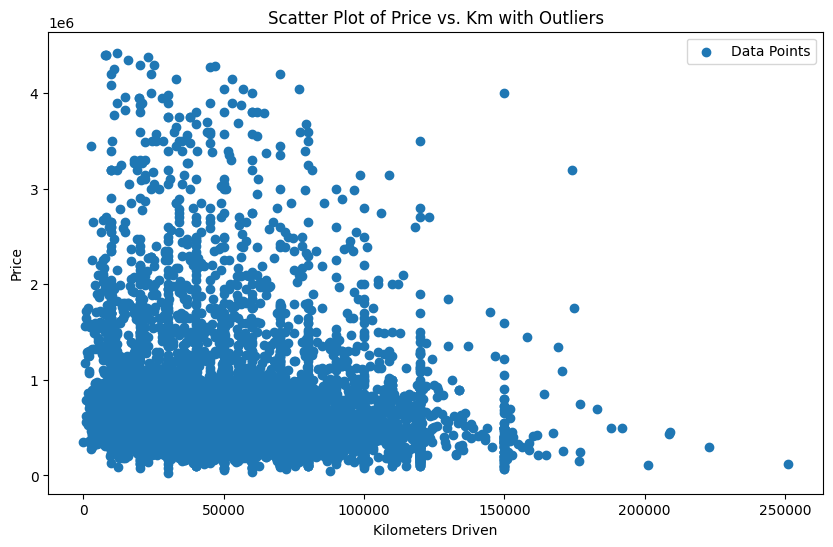

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df11['km'], df11['price'], label='Data Points')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price')
plt.title('Scatter Plot of Price vs. Km with Outliers')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px

# Sample data
data = {
    'km_driven': df11['km'],
    'price': df11['price'],
    'ownerNo': df11['ownerNo'],
    'power': df11['Max Power'],
    'torque': df11['Torque'],
    'age': df11['Car_Age'],
    }

df = pd.DataFrame(data)

# Create a scatter plot
fig = px.scatter(df,
                 x='km_driven',
                 y='price',
                 hover_data=['price', 'km_driven','ownerNo','power','torque','age'],  # Include column data to be shown on hover
                 title='Used Car Prices vs KM Driven',
                 labels={'km_driven': 'Kilometers Driven', 'price': 'Price (INR)'})

# Show the plot
fig.show()


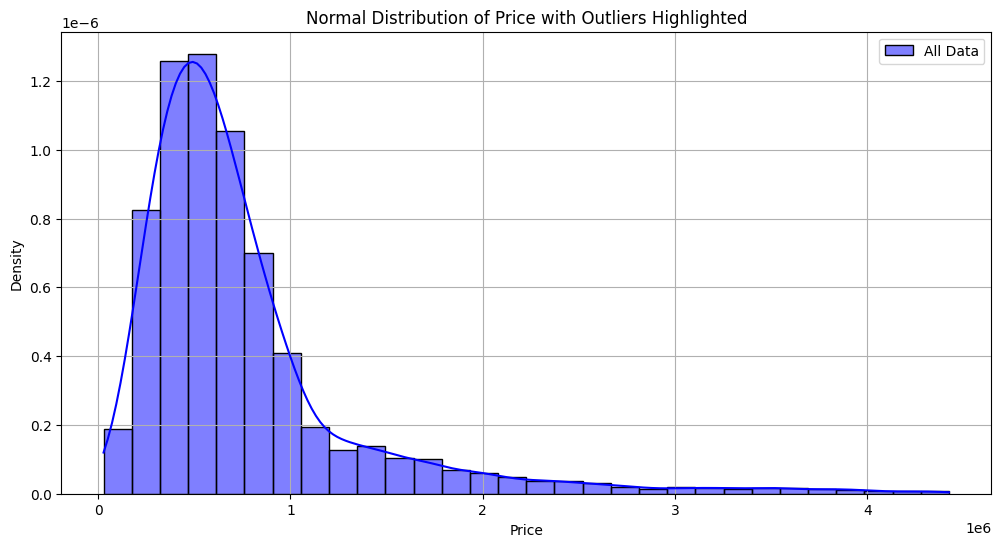

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram and KDE for the entire dataset
sns.histplot(df11['price'], bins=30, kde=True, color='blue', label='All Data', stat='density', alpha=0.5)

# Overlay KDE for outliers
# sns.kdeplot(outliers_zscore['price'], color='red', label='Outliers KDE', lw=2)

# Customizing the plot
plt.title('Normal Distribution of Price with Outliers Highlighted')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

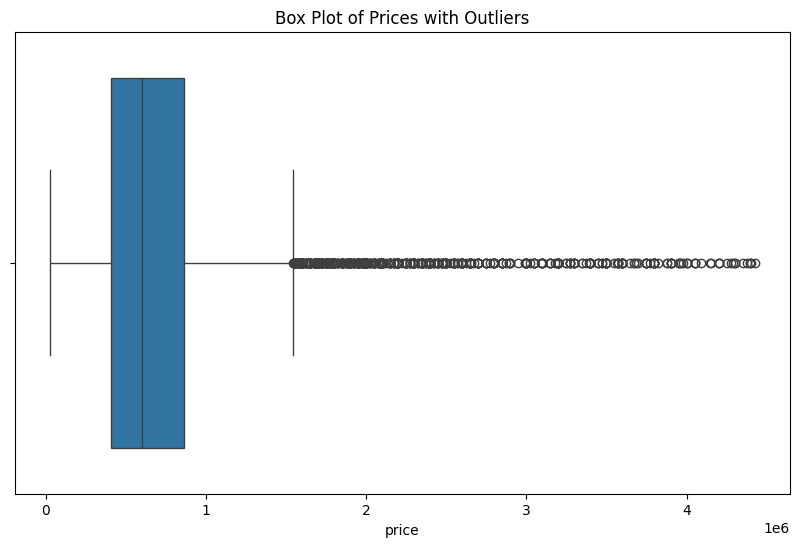

In [ ]:
# Box plot for a specific numerical column
plt.figure(figsize=(10, 6))
sns.boxplot(data=df11, x='price')  # Replace 'price' with any column of interest
plt.title('Box Plot of Prices with Outliers')
plt.show()

### Ranom Forest Model

In [ ]:
import joblib

# Random Forest
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
print(reg.score(X_test, y_test))

joblib.dump(reg, 'random_forest_model.pkl')


0.9198546832343661


['random_forest_model.pkl']

In [ ]:
# Random forst - testing and comparing price

head_rows = df11.head(15)

price_col = head_rows["price"]

head_rows = head_rows.drop("price", axis=1)

pred_prices = reg.predict(head_rows)

pred_prices

comparision_df = pd.DataFrame({"Actual": price_col, "Predicted": pred_prices})
pd.set_option('display.float_format', '{:.2f}'.format)

comparision_df

,Actual,Predicted
0,400000.00,387080.00
1,811000.00,801310.00
2,585000.00,555840.00
3,462000.00,424220.00
4,790000.00,674990.00
5,1900000.00,1831980.00
6,345000.00,324910.00
7,1200000.00,1120600.00
8,960000.00,828860.00
9,585000.00,557210.00


## XG Boost Model

In [ ]:
# XGBoost

# Initialize XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Fit the model
model.fit(X_train, y_train)

model_file = 'xgboost_model_car_pred.json'  # You can use .json or .bin extension
model.save_model(model_file)


# Predict on the test set
y_pred = model.predict(X_test)

# Calculate MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Mean Squared Error: 27348096001.668476
# R-squared: 0.926041358704172

Mean Squared Error: 31965967919.487522
R-squared: 0.9146379021263442


In [ ]:
# XGBoost - testing and comparing price

xgb_head_rows = df11.head(20)

xgb_price_col = xgb_head_rows["price"]

xgb_head_rows = xgb_head_rows.drop("price", axis=1)

xgb_pred_prices = model.predict(xgb_head_rows)

xgb_pred_prices

xgb_comparision_df = pd.DataFrame({"Actual": price_col, "Predicted": pred_prices})
pd.set_option('display.float_format', '{:.2f}'.format)

xgb_comparision_df

,Actual,Predicted
0,400000.00,387080.00
1,811000.00,801310.00
2,585000.00,555840.00
3,462000.00,424220.00
4,790000.00,674990.00
5,1900000.00,1831980.00
6,345000.00,324910.00
7,1200000.00,1120600.00
8,960000.00,828860.00
9,585000.00,557210.00
